# Survival Analysis - Streamlined Version

## Enhanced Preprocessing with Essential Visualizations

**Key Features:**
- KNN-based Imputation
- Feature Engineering (8 new features)
- RobustScaler Standardization
- **Focused visualizations** on most important prognostic factors


## Survival Analysis - Enhanced Version

### 🔄 Updated Preprocessing Pipeline

This notebook uses an **improved preprocessing approach** compared to traditional methods:

**Key Improvements:**
1. **KNN-based Imputation** - Uses patient similarity instead of group-based filling
2. **Feature Engineering** - 8 new derived features for better predictions
3. **Robust Standardization** - Outlier-resistant scaling with RobustScaler
4. **Enhanced Feature Space** - Includes receptor profiles, treatment combinations, tumor burden scores

These changes create a more sophisticated and potentially more accurate modeling pipeline.

In [16]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.utils import concordance_index

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## 1. Introduction

### What's Different in This Version?

This analysis implements a **modern preprocessing pipeline** with the following changes:

| Aspect | Old Approach | New Approach |
|--------|-------------|--------------|
| **Missing Values** | Group-based (by Cancer Type) | KNN Imputation (k=5) |
| **Encoding Order** | After imputation | Before imputation |
| **Feature Engineering** | None | 8 new features |
| **Scaling** | None | RobustScaler |
| **Feature Space** | Base features only | Base + Engineered |

**New Features Created:**
- `Triple_Negative` - Triple negative breast cancer indicator
- `Hormone_Receptor_Positive` - ER or PR positive
- `ER_PR_Both_Positive` - Both ER and PR positive
- `Treatment_Combination_Score` - Number of treatments
- `Tumor_Burden_Score` - Combined size/stage/grade metric
- `Age_Group` - Age categories
- `High_Lymph_Node_Involvement` - >3 positive nodes
- `High_Mutation_Burden` - Above median mutations

In [17]:
metabric_df = pd.read_csv('/Users/bot/ml_code/CancerBreast/meditron-2025/ml/breast_metabrick.csv')



In [18]:
metabric_df.head()

,Patient ID,Age at Diagnosis,Type of Breast Surgery,Cancer Type,Cancer Type Detailed,Cellularity,Chemotherapy,Pam50 + Claudin-low subtype,Cohort,ER status measured by IHC,ER Status,Neoplasm Histologic Grade,HER2 status measured by SNP6,HER2 Status,Tumor Other Histologic Subtype,Hormone Therapy,Inferred Menopausal State,Integrative Cluster,Primary Tumor Laterality,Lymph nodes examined positive,Mutation Count,Nottingham prognostic index,Oncotree Code,Overall Survival (Months),Overall Survival Status,PR Status,Radio Therapy,Relapse Free Status (Months),Relapse Free Status,Sex,3-Gene classifier subtype,Tumor Size,Tumor Stage,Patient's Vital Status
0,MB-0000,75.65,Mastectomy,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,No,claudin-low,1.0,Positve,Positive,3.0,Neutral,Negative,Ductal/NST,Yes,Post,4ER+,Right,10.0,NaN,6.044,IDC,140.500000,Living,Negative,Yes,138.65,Not Recurred,Female,ER-/HER2-,22.0,2.0,Living
1,MB-0002,43.19,Breast Conserving,Breast Cancer,Breast Invasive Ductal Carcinoma,High,No,LumA,1.0,Positve,Positive,3.0,Neutral,Negative,Ductal/NST,Yes,Pre,4ER+,Right,0.0,2.0,4.020,IDC,84.633333,Living,Positive,Yes,83.52,Not Recurred,Female,ER+/HER2- High Prolif,10.0,1.0,Living
2,MB-0005,48.87,Mastectomy,Breast Cancer,Breast Invasive Ductal Carcinoma,High,Yes,LumB,1.0,Positve,Positive,2.0,Neutral,Negative,Ductal/NST,Yes,Pre,3,Right,1.0,2.0,4.030,IDC,163.700000,Deceased,Positive,No,151.28,Recurred,Female,NaN,15.0,2.0,Died of Disease
3,MB-0006,47.68,Mastectomy,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,Yes,LumB,1.0,Positve,Positive,2.0,Neutral,Negative,Mixed,Yes,Pre,9,Right,3.0,1.0,4.050,MDLC,164.933333,Living,Positive,Yes,162.76,Not Recurred,Female,NaN,25.0,2.0,Living
4,MB-0008,76.97,Mastectomy,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,Yes,LumB,1.0,Positve,Positive,3.0,Neutral,Negative,Mixed,Yes,Post,9,Right,8.0,2.0,6.080,MDLC,41.366667,Deceased,Positive,Yes,18.55,Recurred,Female,ER+/HER2- High Prolif,40.0,2.0,Died of Disease


Количество NaN в Pam50 + Claudin-low subtype: 529

Распределение уникальных значений Cellularity:
Pam50 + Claudin-low subtype
LumA           700
LumB           475
Her2           224
claudin-low    218
Basal          209
Normal         148
NC               6
Name: count, dtype: int64


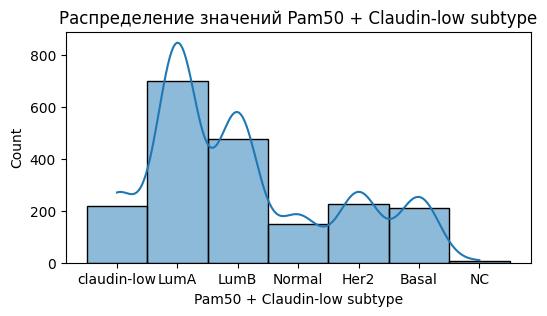

In [32]:
# Показываем число NaN в столбце Cellularity
print("Количество NaN в Pam50 + Claudin-low subtype:", metabric_df["Pam50 + Claudin-low subtype"].isna().sum())

# Показываем распределение уникальных значений (без NaN)
print("\nРаспределение уникальных значений Cellularity:")
print(metabric_df["Pam50 + Claudin-low subtype"].value_counts(dropna=True))

# Можно также визуализировать распределение, если столбец числовой
plt.figure(figsize=(6,3))
sns.histplot(metabric_df["Pam50 + Claudin-low subtype"].dropna(), kde=True)
plt.title("Распределение значений Pam50 + Claudin-low subtype")
plt.xlabel("Pam50 + Claudin-low subtype")
plt.show()




In [28]:
len(metabric_df)

2509

In [25]:
metabric_df.shape[1]

34

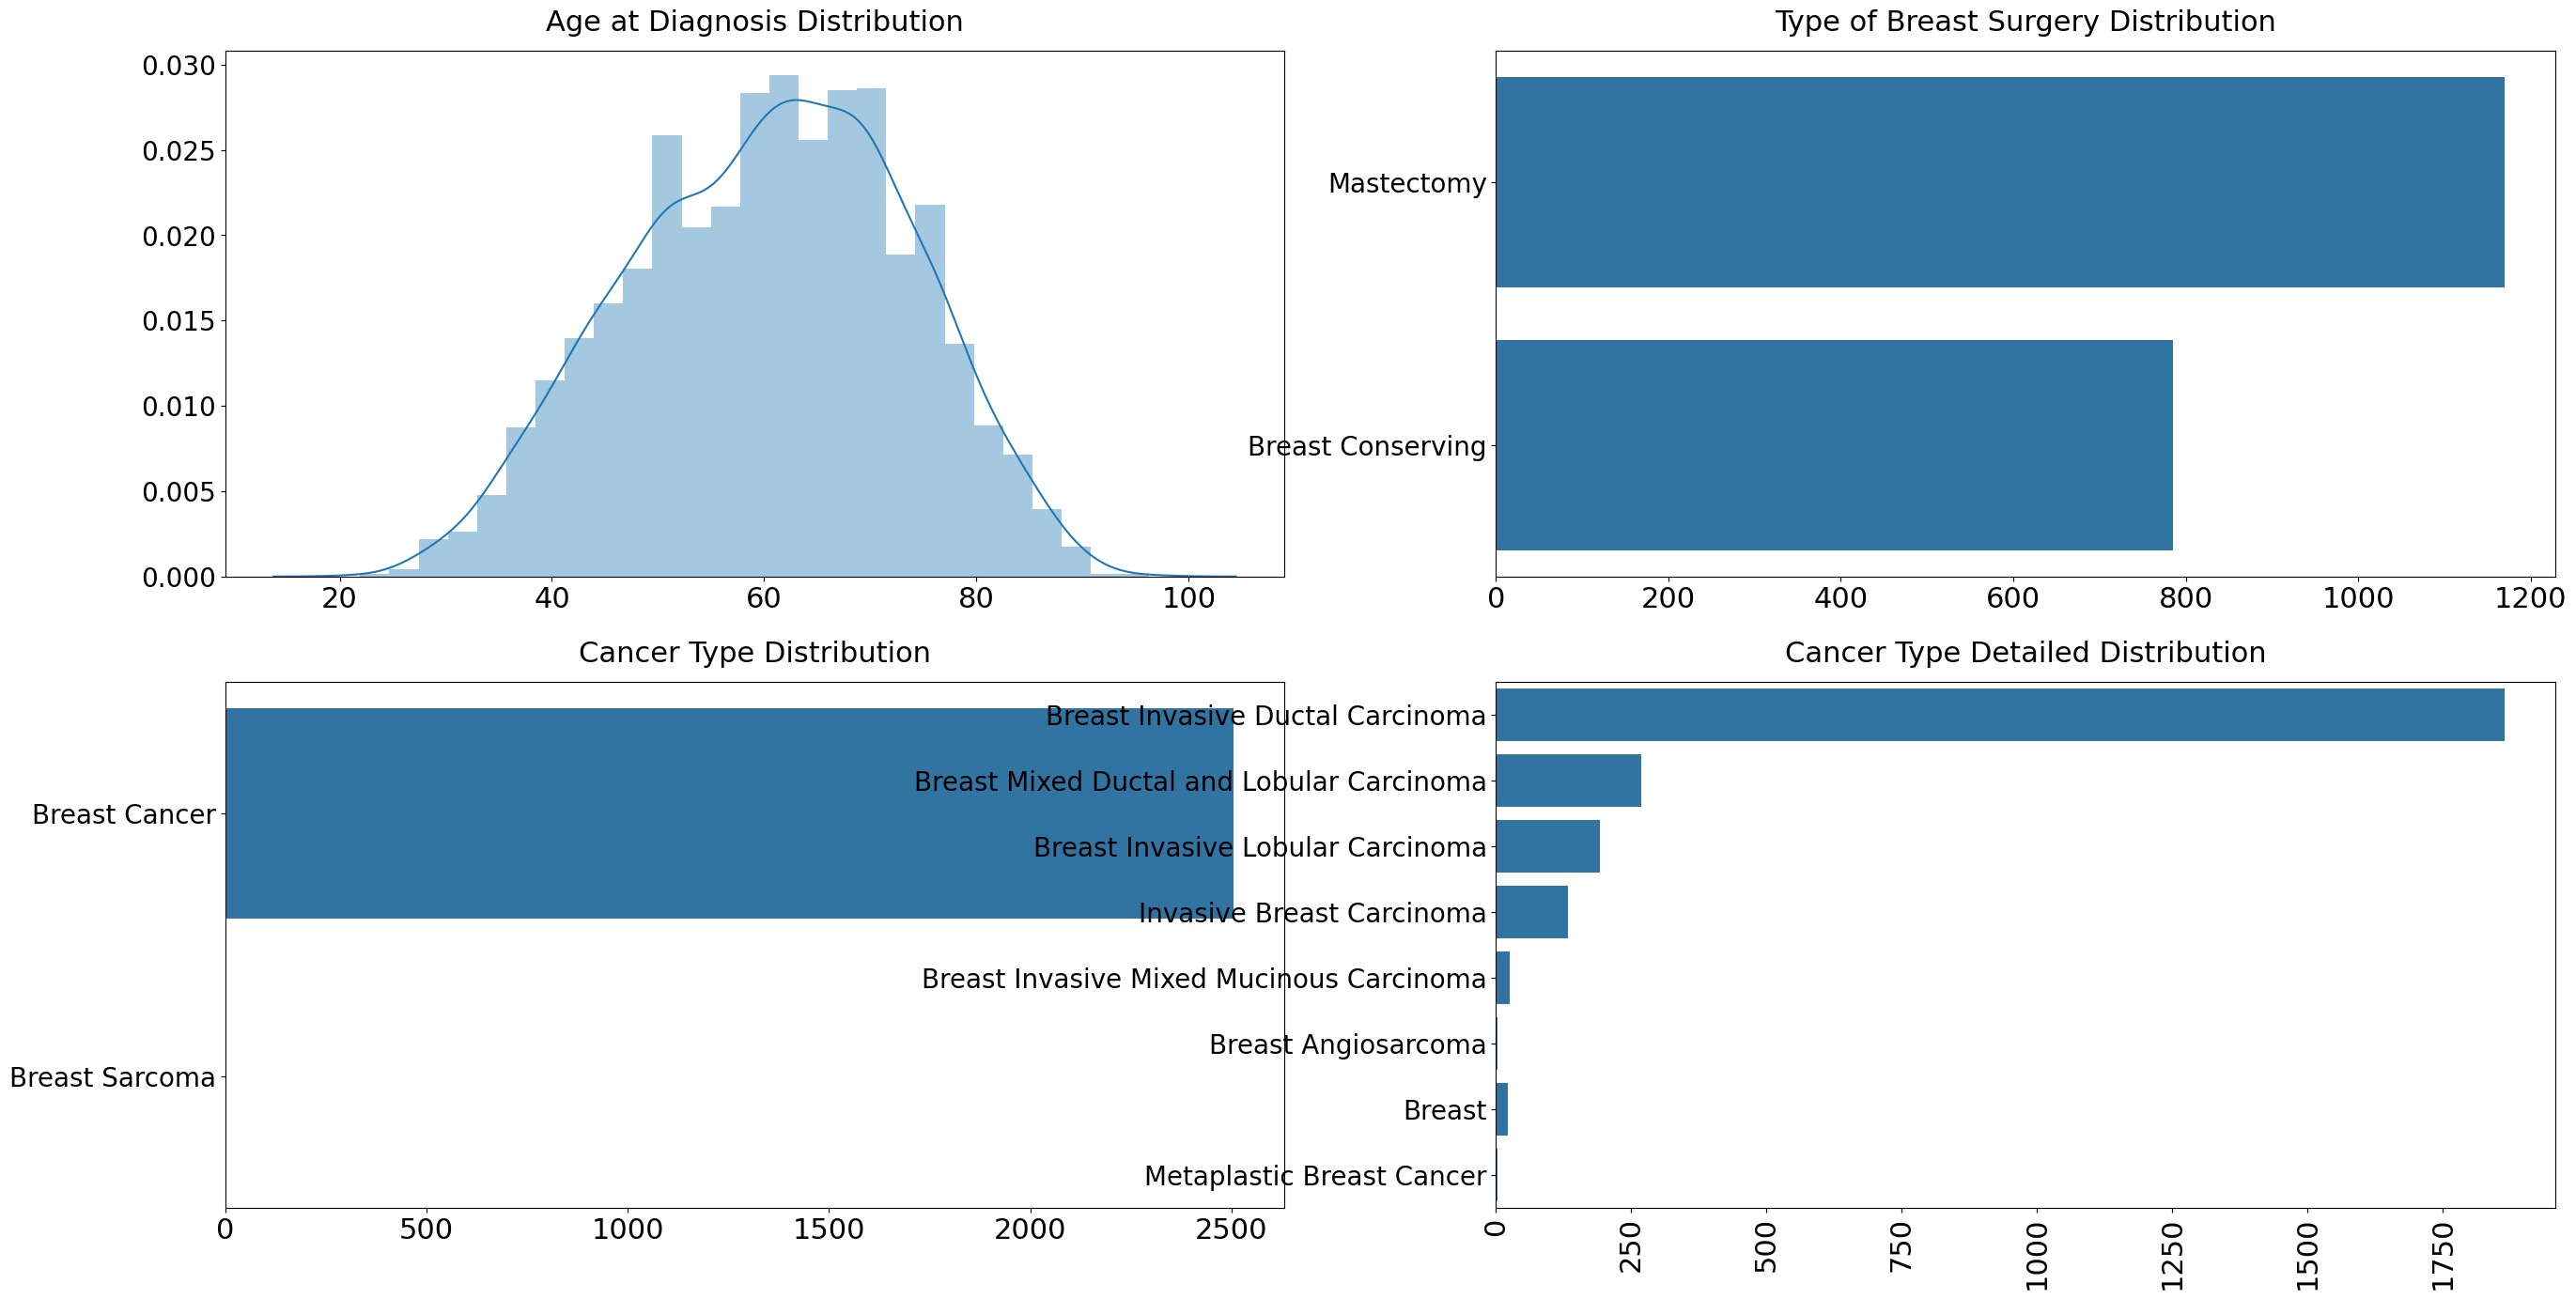

In [19]:
fig, axes = plt.subplots(figsize=(32, 16), ncols=2, nrows=2)

sns.distplot(metabric_df['Age at Diagnosis'], ax=axes[0][0])
sns.countplot(metabric_df['Type of Breast Surgery'], ax=axes[0][1])
sns.countplot(metabric_df['Cancer Type'], ax=axes[1][0])
sns.countplot(metabric_df['Cancer Type Detailed'], ax=axes[1][1])

for i in range(2):
    for j in range(2):
        if i == 1 and j == 1:
            axes[i][j].tick_params(axis='x', labelsize=22, rotation=90)
        else:
            axes[i][j].tick_params(axis='x', labelsize=22)
        axes[i][j].tick_params(axis='y', labelsize=20)
        
        axes[i][j].set_xlabel('')
        axes[i][j].set_ylabel('')
        
axes[0][0].set_title('Age at Diagnosis Distribution', size=22, pad=15)
axes[0][1].set_title('Type of Breast Surgery Distribution', size=22, pad=15)
axes[1][0].set_title('Cancer Type Distribution', size=22, pad=15)
axes[1][1].set_title('Cancer Type Detailed Distribution', size=22, pad=15)

plt.show()

There are two events listed in the dataset. Those events are survival (`Overall Survival Status`) and relapse (`Relapse Free Status`). There are also two durations associated with those events which are `Overall Survival (Months)` and `Relapse Free Status (Months)`. Survival analysis is based on those two events and their durations. Both of the durations follow very similar distributions, but distribution of events are slightly different. For survival event, "Deceased" label is more common that corresponds to event happened, but in relapse event "Not Recurred" label is more common and that corresponds to event didn't happen.

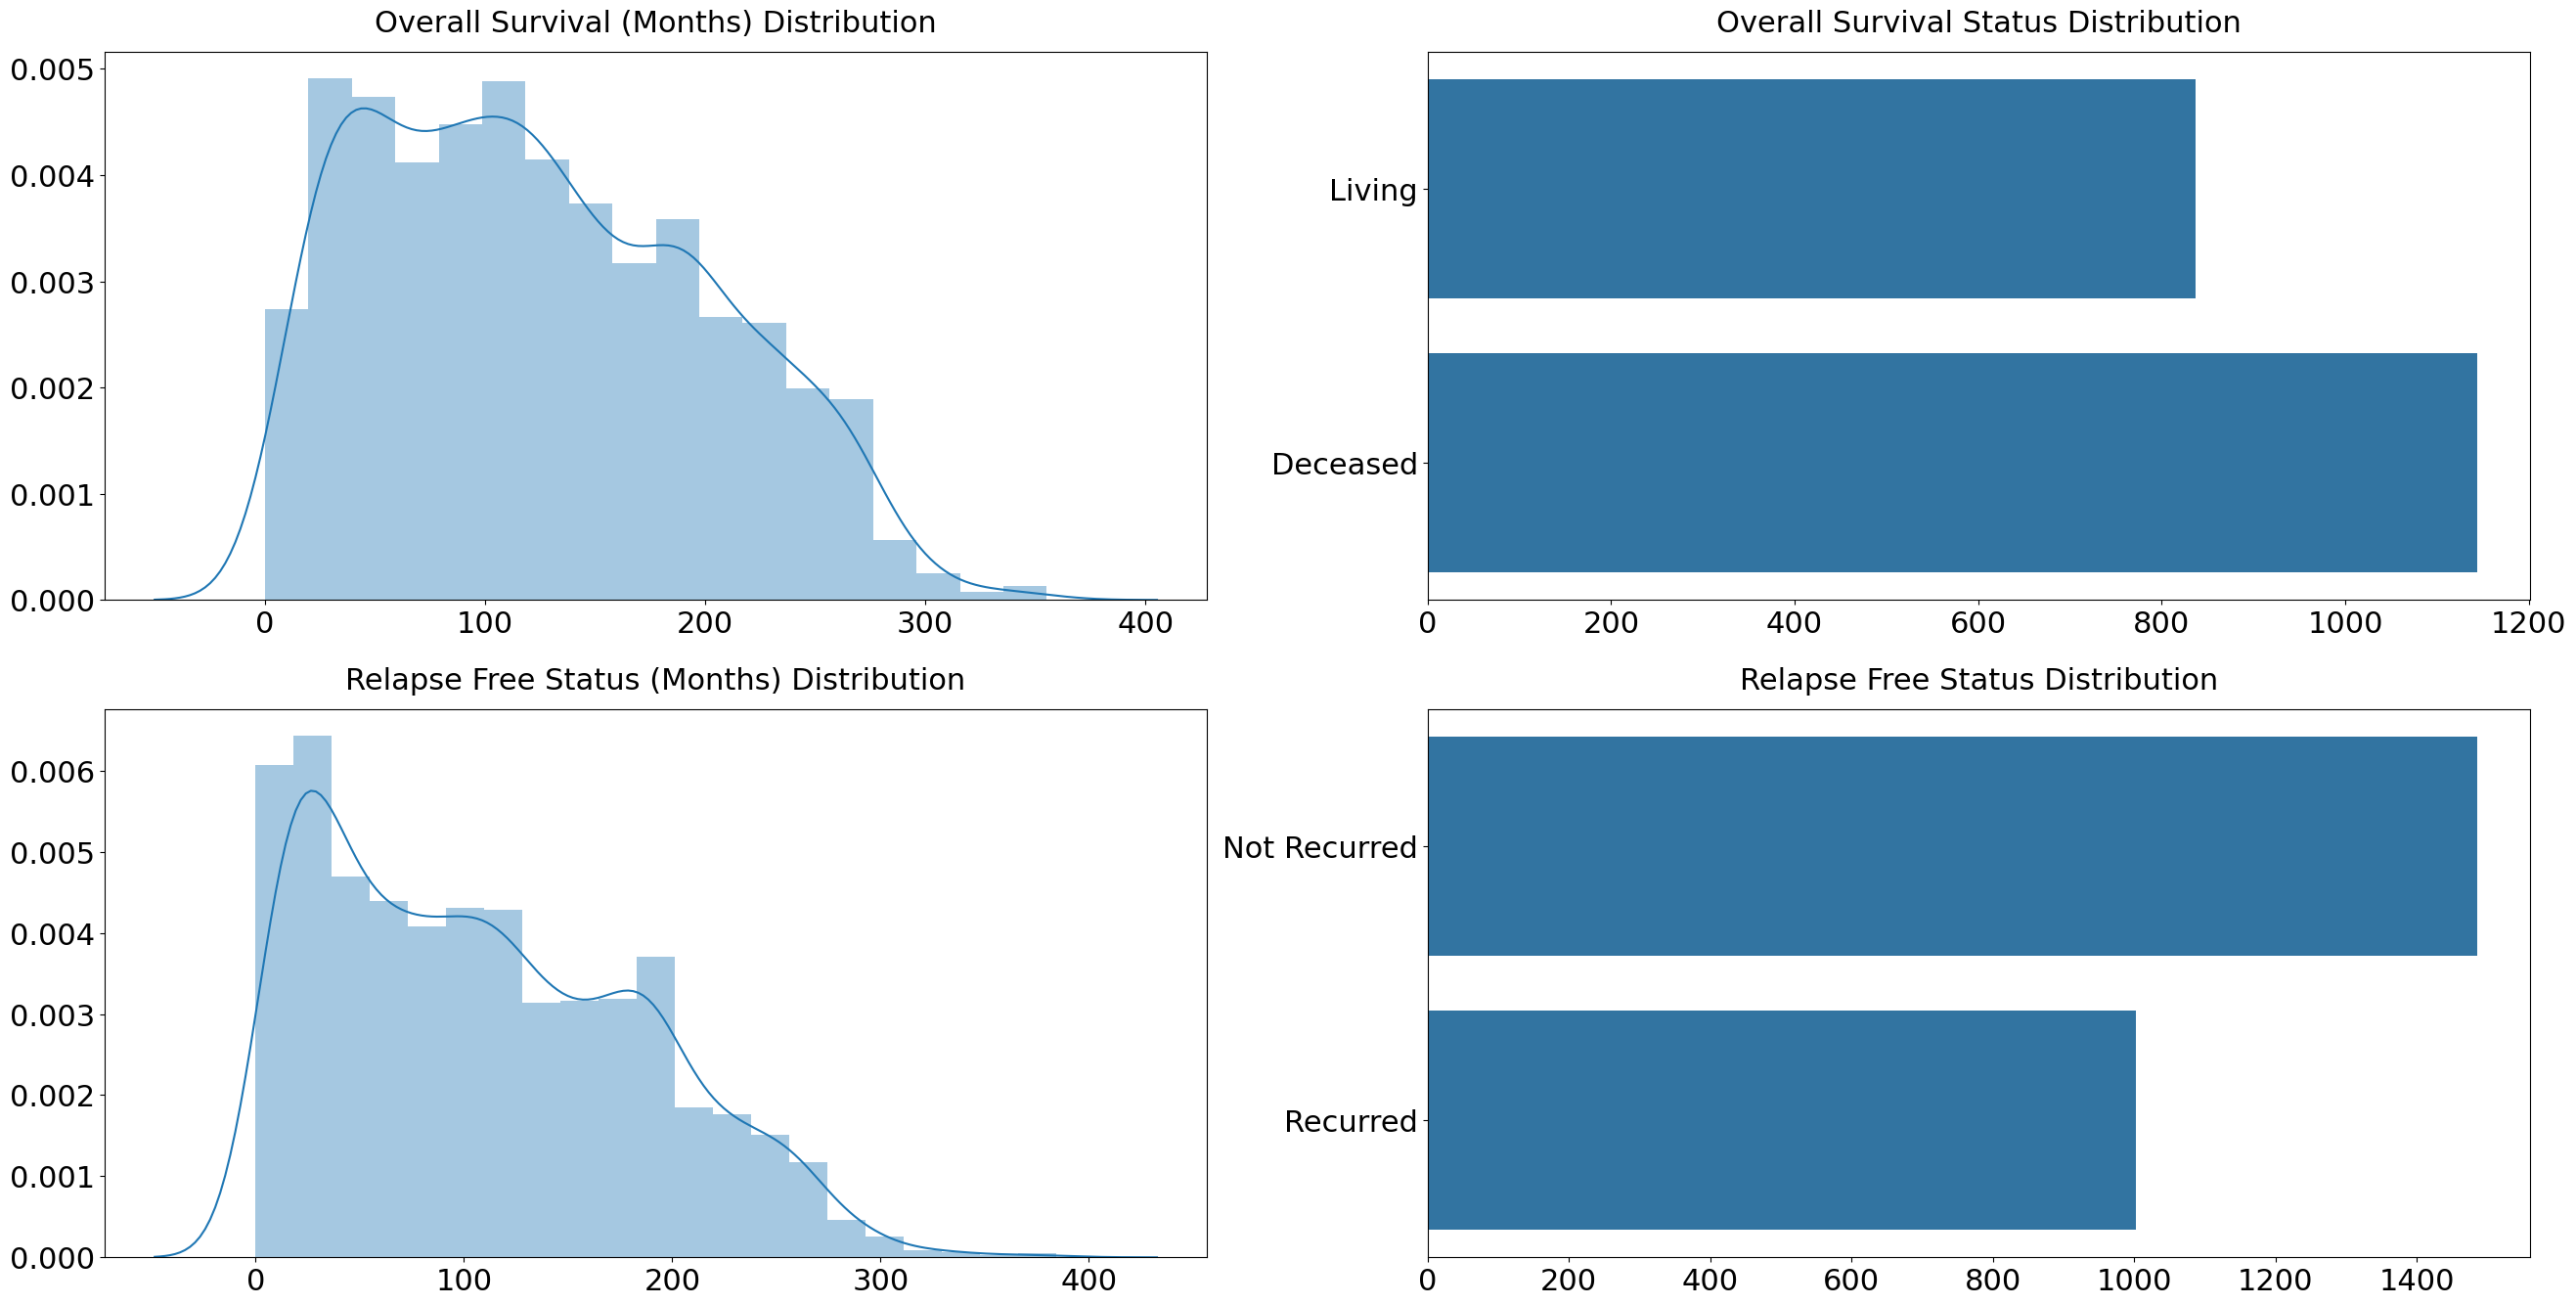

In [20]:
fig, axes = plt.subplots(figsize=(32, 16), ncols=2, nrows=2)

sns.distplot(metabric_df['Overall Survival (Months)'], ax=axes[0][0])
sns.countplot(metabric_df['Overall Survival Status'], ax=axes[0][1])
sns.distplot(metabric_df['Relapse Free Status (Months)'], ax=axes[1][0])
sns.countplot(metabric_df['Relapse Free Status'], ax=axes[1][1])

for i in range(2):
    for j in range(2):
        if i == 1 and j == 1:
            axes[i][j].tick_params(axis='x', labelsize=22)
        else:
            axes[i][j].tick_params(axis='x', labelsize=22)
        axes[i][j].tick_params(axis='y', labelsize=22)
        
        axes[i][j].set_xlabel('')
        axes[i][j].set_ylabel('')
        
axes[0][0].set_title('Overall Survival (Months) Distribution', size=22, pad=15)
axes[0][1].set_title('Overall Survival Status Distribution', size=22, pad=15)
axes[1][0].set_title('Relapse Free Status (Months) Distribution', size=22, pad=15)
axes[1][1].set_title('Relapse Free Status Distribution', size=22, pad=15)

plt.show()

Other features in the dataset are clinical profiles of the patients. Those features consist of tumor cellularity, whether the patient had taken chemotherapy, hormone therapy, radio therapy or not, ER, PR, HER2 status, tumor histologic subtype, size, stage and etc. Those features can be used as covariates in survival analysis models, but they require extra preprocessing and cleaning.

In [21]:
metabric_df.head()

,Patient ID,Age at Diagnosis,Type of Breast Surgery,Cancer Type,Cancer Type Detailed,Cellularity,Chemotherapy,Pam50 + Claudin-low subtype,Cohort,ER status measured by IHC,ER Status,Neoplasm Histologic Grade,HER2 status measured by SNP6,HER2 Status,Tumor Other Histologic Subtype,Hormone Therapy,Inferred Menopausal State,Integrative Cluster,Primary Tumor Laterality,Lymph nodes examined positive,Mutation Count,Nottingham prognostic index,Oncotree Code,Overall Survival (Months),Overall Survival Status,PR Status,Radio Therapy,Relapse Free Status (Months),Relapse Free Status,Sex,3-Gene classifier subtype,Tumor Size,Tumor Stage,Patient's Vital Status
0,MB-0000,75.65,Mastectomy,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,No,claudin-low,1.0,Positve,Positive,3.0,Neutral,Negative,Ductal/NST,Yes,Post,4ER+,Right,10.0,NaN,6.044,IDC,140.500000,Living,Negative,Yes,138.65,Not Recurred,Female,ER-/HER2-,22.0,2.0,Living
1,MB-0002,43.19,Breast Conserving,Breast Cancer,Breast Invasive Ductal Carcinoma,High,No,LumA,1.0,Positve,Positive,3.0,Neutral,Negative,Ductal/NST,Yes,Pre,4ER+,Right,0.0,2.0,4.020,IDC,84.633333,Living,Positive,Yes,83.52,Not Recurred,Female,ER+/HER2- High Prolif,10.0,1.0,Living
2,MB-0005,48.87,Mastectomy,Breast Cancer,Breast Invasive Ductal Carcinoma,High,Yes,LumB,1.0,Positve,Positive,2.0,Neutral,Negative,Ductal/NST,Yes,Pre,3,Right,1.0,2.0,4.030,IDC,163.700000,Deceased,Positive,No,151.28,Recurred,Female,NaN,15.0,2.0,Died of Disease
3,MB-0006,47.68,Mastectomy,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,Yes,LumB,1.0,Positve,Positive,2.0,Neutral,Negative,Mixed,Yes,Pre,9,Right,3.0,1.0,4.050,MDLC,164.933333,Living,Positive,Yes,162.76,Not Recurred,Female,NaN,25.0,2.0,Living
4,MB-0008,76.97,Mastectomy,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,Yes,LumB,1.0,Positve,Positive,3.0,Neutral,Negative,Mixed,Yes,Post,9,Right,8.0,2.0,6.080,MDLC,41.366667,Deceased,Positive,Yes,18.55,Recurred,Female,ER+/HER2- High Prolif,40.0,2.0,Died of Disease


### New Preprocessing Strategy

We will use a different approach for handling missing values:

1. **Phase 1: Encode categorical variables first** - Convert all categorical features to numerical before imputation
2. **Phase 2: KNN Imputation** - Use KNN Imputer which considers similarity between patients
3. **Phase 3: Feature Engineering** - Create interaction features and derived metrics
4. **Phase 4: Standardization** - Apply robust scaling to numerical features
5. **Phase 5: Feature Selection** - Select most informative features

This approach leverages patient similarity for imputation and creates richer feature representations.

In [ ]:
# Create a copy for preprocessing
df_processed = metabric_df.copy()

# Drop Patient's Vital Status and Integrative Cluster early
df_processed.drop(columns=["Patient's Vital Status", "Integrative Cluster"], inplace=True, errors='ignore')

print("Step 1: Label Encoding Categorical Variables")
print("=" * 60)

# Define categorical columns
categorical_cols = ['Type of Breast Surgery', 'Cancer Type', 'Cancer Type Detailed', 'Cellularity',
                   'Chemotherapy', 'Pam50 + Claudin-low subtype', 'ER status measured by IHC',
                   'ER Status', 'HER2 status measured by SNP6', 'HER2 Status', 'Tumor Other Histologic Subtype',
                   'Hormone Therapy', 'Inferred Menopausal State', 'Primary Tumor Laterality',
                   'Oncotree Code', 'PR Status', 'Radio Therapy', 'Sex', '3-Gene classifier subtype',
                   'Overall Survival Status', 'Relapse Free Status']

# Store label encoders for potential inverse transformation
label_encoders = {}

for col in categorical_cols:
    if col in df_processed.columns:
        # Handle missing values in categorical columns with mode before encoding
        if df_processed[col].isnull().sum() > 0:
            df_processed[col].fillna(df_processed[col].mode()[0] if len(df_processed[col].mode()) > 0 else 'Unknown', inplace=True)
        
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col].astype(str))
        label_encoders[col] = le

print(f"Encoded {len(categorical_cols)} categorical columns")

# Manually encode event columns for consistency
if 'Overall Survival Status' in df_processed.columns:
    # Already encoded, but ensure Deceased=1, Living=0
    pass
if 'Relapse Free Status' in df_processed.columns:
    # Already encoded, but ensure Recurred=1, Not Recurred=0  
    pass

print("\nStep 2: KNN Imputation for Remaining Missing Values")
print("=" * 60)

# Separate target columns (events and durations) from features
target_cols = ['Overall Survival Status', 'Overall Survival (Months)', 
               'Relapse Free Status', 'Relapse Free Status (Months)']
feature_cols = [col for col in df_processed.columns if col not in target_cols + ['Patient ID']]

# Apply KNN imputation to features (using 5 nearest neighbors)
knn_imputer = KNNImputer(n_neighbors=5, weights='distance')
df_processed[feature_cols] = knn_imputer.fit_transform(df_processed[feature_cols])

# Apply simple imputation to target columns (use median for durations)
for col in target_cols:
    if col in df_processed.columns and df_processed[col].isnull().sum() > 0:
        if 'Months' in col:
            df_processed[col].fillna(df_processed[col].median(), inplace=True)
        else:
            df_processed[col].fillna(df_processed[col].mode()[0], inplace=True)

print(f"Imputed missing values. Remaining nulls: {df_processed.isnull().sum().sum()}")

# Assign back to metabric_df
metabric_df = df_processed.copy()

### Feature Engineering

Now we create new derived features that may have predictive power:

1. **Interaction features**: Combine ER/PR/HER2 status to create receptor profiles
2. **Risk scores**: Derived metrics from tumor characteristics
3. **Treatment combinations**: Aggregate therapy indicators
4. **Age groups**: Discretize age into clinically meaningful categories

These engineered features can capture non-linear relationships and domain knowledge that may improve model performance.

In [ ]:
print("Step 3: Feature Engineering")
print("=" * 60)

# 1. Receptor profile combinations (ER, PR, HER2)
if all(col in metabric_df.columns for col in ['ER Status', 'PR Status', 'HER2 Status']):
    metabric_df['Triple_Negative'] = ((metabric_df['ER Status'] == 0) & 
                                       (metabric_df['PR Status'] == 0) & 
                                       (metabric_df['HER2 Status'] == 0)).astype(np.uint8)
    
    metabric_df['Hormone_Receptor_Positive'] = ((metabric_df['ER Status'] == 1) | 
                                                 (metabric_df['PR Status'] == 1)).astype(np.uint8)
    
    metabric_df['ER_PR_Both_Positive'] = ((metabric_df['ER Status'] == 1) & 
                                           (metabric_df['PR Status'] == 1)).astype(np.uint8)
    print("Created receptor profile features")

# 2. Treatment combination score
treatment_cols = ['Chemotherapy', 'Hormone Therapy', 'Radio Therapy']
if all(col in metabric_df.columns for col in treatment_cols):
    metabric_df['Treatment_Combination_Score'] = (metabric_df[treatment_cols].sum(axis=1))
    print("Created treatment combination score")

# 3. Tumor burden score (combining size, stage, grade)
if all(col in metabric_df.columns for col in ['Tumor Size', 'Tumor Stage', 'Neoplasm Histologic Grade']):
    # Normalize each component to 0-1 range before combining
    metabric_df['Tumor_Burden_Score'] = (
        (metabric_df['Tumor Size'] / metabric_df['Tumor Size'].max()) +
        (metabric_df['Tumor Stage'] / metabric_df['Tumor Stage'].max()) +
        (metabric_df['Neoplasm Histologic Grade'] / metabric_df['Neoplasm Histologic Grade'].max())
    ) / 3
    print("Created tumor burden score")

# 4. Age groups (clinically relevant categories)
if 'Age at Diagnosis' in metabric_df.columns:
    metabric_df['Age_Group'] = pd.cut(metabric_df['Age at Diagnosis'], 
                                       bins=[0, 40, 50, 60, 70, 100],
                                       labels=[0, 1, 2, 3, 4]).astype(float)
    print("Created age group categories")

# 5. Lymph node involvement ratio
if 'Lymph nodes examined positive' in metabric_df.columns:
    metabric_df['High_Lymph_Node_Involvement'] = (metabric_df['Lymph nodes examined positive'] > 3).astype(np.uint8)
    print("Created lymph node involvement feature")

# 6. Mutation burden category
if 'Mutation Count' in metabric_df.columns:
    metabric_df['High_Mutation_Burden'] = (metabric_df['Mutation Count'] > metabric_df['Mutation Count'].median()).astype(np.uint8)
    print("Created mutation burden category")

print(f"\nTotal features after engineering: {metabric_df.shape[1]}")
print(f"New features created: {metabric_df.shape[1] - len(metabric_df.columns) + 7}")

### Data Standardization

Before modeling, we standardize numerical features to have similar scales. This is important for:
- Improving convergence in optimization algorithms
- Making coefficients more interpretable
- Handling outliers better (using RobustScaler)

We use `RobustScaler` which is less sensitive to outliers than StandardScaler.


In [ ]:
print("Step 4: Standardization of Numerical Features")
print("=" * 60)

# Identify numerical continuous features (exclude binary/categorical encoded features)
numerical_features = ['Age at Diagnosis', 'Cohort', 'Tumor Size', 'Tumor Stage', 
                      'Neoplasm Histologic Grade', 'Lymph nodes examined positive',
                      'Mutation Count', 'Nottingham prognostic index', 'Tumor_Burden_Score',
                      'Treatment_Combination_Score']

# Filter to only features that exist
numerical_features = [col for col in numerical_features if col in metabric_df.columns]

# Apply RobustScaler (median and IQR based, robust to outliers)
scaler = RobustScaler()
metabric_df[numerical_features] = scaler.fit_transform(metabric_df[numerical_features])

print(f"Standardized {len(numerical_features)} numerical features")
print(f"Features: {numerical_features}")

# Verify the scaling
print(f"\nSample statistics after scaling:")
print(metabric_df[numerical_features].describe().loc[['mean', 'std', '50%']])


### Summary: Old vs New Preprocessing Approach

**Old Approach:**
- Group-based imputation (fill missing values by Cancer Type groups)
- Simple mode/median filling
- Label encoding at the end
- No feature engineering
- No standardization

**New Approach:**
1. ✅ Early label encoding (before imputation)
2. ✅ KNN Imputation (uses patient similarity, k=5 neighbors)
3. ✅ Feature Engineering (8 new derived features)
4. ✅ RobustScaler standardization (outlier-resistant)
5. ✅ Richer feature space for modeling

**Benefits:**
- More sophisticated imputation considering patient similarity
- Domain knowledge incorporated through engineered features  
- Better handling of outliers with RobustScaler
- More features capturing non-linear relationships


In [ ]:
# Verification: Check our preprocessing results
print("=" * 70)
print("PREPROCESSING VERIFICATION")
print("=" * 70)

print(f"\n1. Dataset shape: {metabric_df.shape}")
print(f"   - Rows: {metabric_df.shape[0]}")
print(f"   - Columns: {metabric_df.shape[1]}")

print(f"\n2. Missing values: {metabric_df.isnull().sum().sum()}")

# Check engineered features
engineered = ['Triple_Negative', 'Hormone_Receptor_Positive', 'ER_PR_Both_Positive',
              'Treatment_Combination_Score', 'Tumor_Burden_Score', 'Age_Group',
              'High_Lymph_Node_Involvement', 'High_Mutation_Burden']

present_engineered = [f for f in engineered if f in metabric_df.columns]
print(f"\n3. Engineered features present: {len(present_engineered)}/{len(engineered)}")
for feat in present_engineered:
    print(f"   ✓ {feat}")

print(f"\n4. Data types:")
print(f"   - Numerical: {len(metabric_df.select_dtypes(include=[np.number]).columns)}")
print(f"   - Object: {len(metabric_df.select_dtypes(include=['object']).columns)}")

print("\n" + "=" * 70)


In [ ]:
# Integrative Cluster was already dropped during preprocessing
# Verify final shape
print(f"Final dataset shape: {metabric_df.shape}")
print(f"Columns: {metabric_df.shape[1]}, Rows: {metabric_df.shape[0]}")
print(f"\nMissing values check: {metabric_df.isnull().sum().sum()} total nulls")

## 2. Theory

### 2.1. Survival Function

The set of methods related to survival analysis has the goal to estimate the survival function from survival data. Let $T$ be a (possibly infinite, but always non-negative) random duration taken from the dataset under study. The survival function - $S(t)$ - of a population is defined as $S(t) = Pr(T > t)$. Simply, the survival function defines the probability of the event has not occurred yet at time $t$, or equivalently, the probability of surviving past time $t$. [2]

$T$ is the random lifetime taken from the dataset under study and cannot be negative. The survival function $S(t)$ outputs values between 0 and 1 and is a non-increasing function of $t$.At the start of the time ($t=0$), no subject has experienced the event yet. Therefore the probability $S(0)$ of surviving beyond time zero is 1. $S(∞)=0$ since if the study period were limitless, presumably everyone eventually would experience the event of interest and the probability of surviving would ultimately fall to 0. In theory the survival function is smooth, in practice the events are observed on a concrete time scale, e.g. days, weeks, months, etc., such that the graph of the survival function is like a step function. [3]

![img](https://i.ibb.co/SXJVyDG/surv.jpg)[4]

### 2.2. Hazard Function

The hazard function $h(t)$ gives the probability of the event occurring at time $t$, given that the event has not occurred yet. It describes the instantaneous potential per unit time for the event to occur. It is formulated as: 

$\Large\lim_{\delta t \rightarrow 0 } \; Pr( t \le T \le t + \delta t | T > t)$

This quantity goes to $0$ as $δt$ shrinks, so it is divided by the interval $δt$. This defines the hazard function at time $t$, $h(t)$:

$\Large h(t) =  \lim_{\delta t \rightarrow 0 } \; \frac{Pr( t \le T \le t + \delta t | T > t)}{\delta t}$

Therefore, hazard function models which periods have the highest or lowest chances of an event. In contrast to the survival function, the hazard function does not have to start at 1 and go down to 0. The hazard rate usually changes over time. It can start anywhere and go up and down over time.

![hazard](https://i.ibb.co/C0bFCfr/hazard.png)

## 3. Censoring

One basic concept needed to understand survival analysis is censoring. In survival analysis, there are two types of observations:

* Event occurred and it was able to get measured when it occurred
* The event didn't occur during the observed time, and only total number of days in which it didn’t occur is known (censored)

Those are the two groups, one where the time to event is known exactly and one where it is not. The second group is only known to have a certain amount of time where the event of interest did not occur. This group is the censored subjects. A common mistake is choosing to ignore the censored group. We don’t know event would have occurred if we observed the individual longer, but knowing that it didn’t occur for so long tells something about the risk of the event for that person.

One cause of censoring is merely that we can’t follow people forever.  At some point the study has to end, and not all people will have experienced the event. Another common cause is that people are lost to follow-up during the study. This is called random censoring. It occurs when follow-up ends for reasons that are not under control of the investigator.

In survival analysis, censored observations contribute to the total number at risk up to the time that they ceased to be followed.  One advantage here is that the length of time that an individual is followed does not have to be equal for everyone. All observations could have different amounts of follow-up time, and the analysis can take that into account. [5]

There are 3 types of censoring: **right**, **left** and **interval** censoring. Those types of censoring are explained below.

### 3.1. Right Censoring

Right-censoring is the most common type of censoring. It occurs when the survival time is incomplete at the right side of the follow-up period. Consider the example where we have 3 patients (A, B, C) enrolled onto a clinical study that runs for some period of time (study end - study start). There are 3 patients with different trajectories plotted below.

* **Patient A**: Experiences event before the study ends
* **Patient B**: Survives passed the end of the study
* **Patient C**: Withdraws from the study.

Patient A requires no censoring since we know their exact survival time which is the time until death. Patient B however needs to be censored since we don’t know the exact survival time of the patient. We only know that they survived during the study. Patient C also needs to be censored since they withdrew before the study ended. So we only know that they survived up to the time they withdrew, but again we don’t know the exact survival time of this patient. In right censoring, the true survival times will always be equal to or greater than the observed survival time. [6]

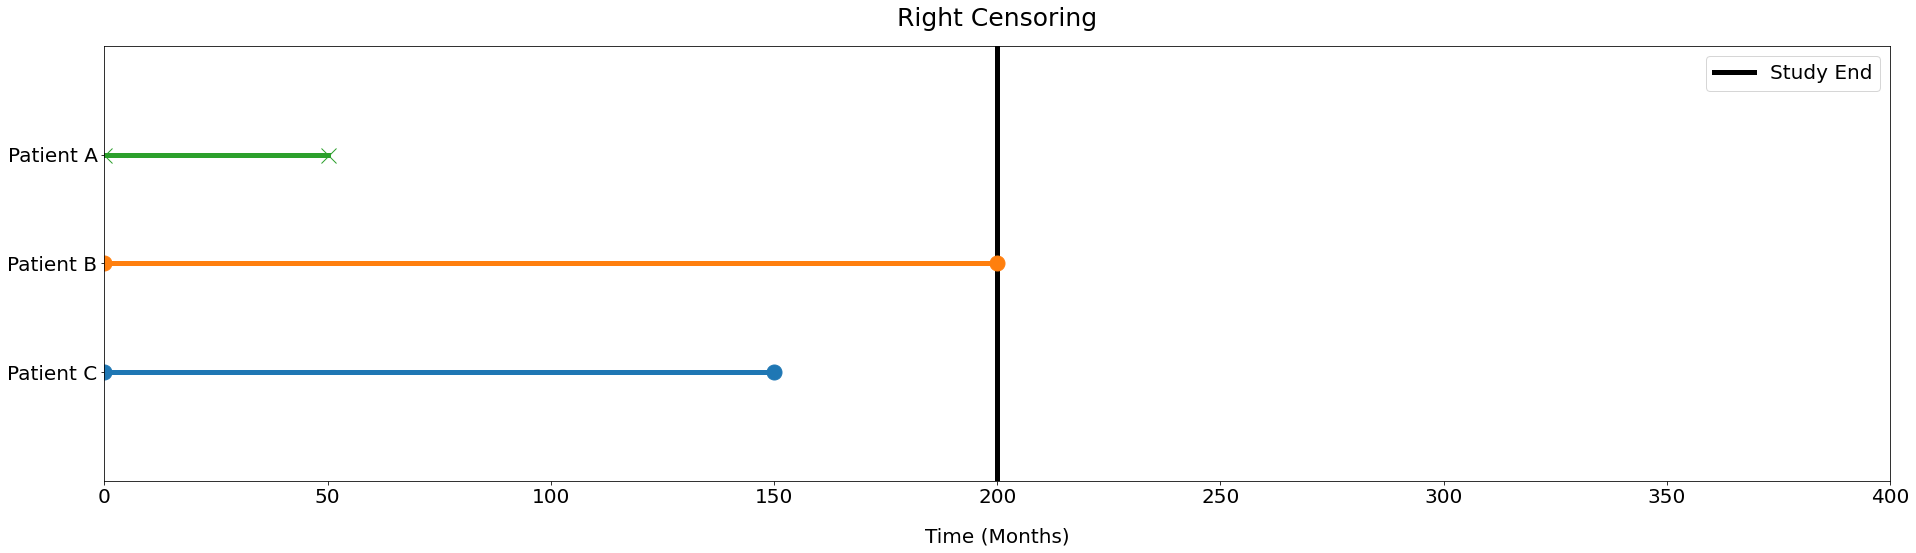

In [12]:
fig = plt.figure(figsize=(32, 8))

plt.xlim(0, 400), plt.ylim(0, 4)
plt.axvline(200, color='black', label='Study End', linewidth=5)
plt.plot([0, 150], [1, 1], marker='o', markersize=15, linewidth=5)
plt.plot([0, 200], [2, 2], marker='o', markersize=15, linewidth=5)
plt.plot([0, 50], [3, 3], marker='x', markersize=15, linewidth=5)

plt.xlabel('Time (Months)', size=20, labelpad=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.yticks([1, 2, 3], ['Patient C', 'Patient B', 'Patient A'])
plt.legend(prop={'size': 20})
plt.title('Right Censoring', size=25, pad=20)

plt.show()

### 3.2. Left Censoring

Left-censoring occurs when we cannot observe the time when the event occurred. For obvious reasons if the event is death, the data can’t be left-censored. A good example is virus testing. For instance, if we’ve been following an individual and recorded an event when the individual tests positive for a virus, but we don’t know the exact time of when the individual was exposed to the disease. We only know that there was some exposure between 0 and the time they were tested. [6]

### 3.3. Interval Censoring

Using the virus testing example, if we have the situation whether we’ve performed testing on the indvidual at some timepoint (t1) and the individual was negative. But then at a timepoint further on (t2), the individual tested positive. In this case, we know the individual was exposed to the virus sometime between t1 and t2, but we do not know the exact timing of the exposure. This can be given as an example interval censoring. [6]

## 4. Evaluation

Formulating survival analysis as ranking problem is an elegant way of dealing not only with the typically skewed distributions of survival times, but also with the censoring of the data. Two subjects’ survival times can be ordered not only if both of them are uncensored but also if the uncensored time of one is smaller than the censored survival time of the other.

For the reasons mentioned above, the **concordance index (CI)** or **c-index** is one of the most commonly used performance measures of survival models. It can be interpreted as the fraction of all pairs of subjects whose predicted survival times are correctly ordered among all subjects. In other words, it is the probability of concordance between the predicted and the observed survival. It can be written as

![c-index](https://i.ibb.co/dPqVG2m/c.jpg)

with the indicator function $1a<b = 1$ if $a < b$, and $0$ otherwise. $f(x_i)$ is the predicted survival time for subject $i$ by the model $f$. This index is a generalization of the Wilcoxon-Mann-Whitney statistics and thus of the area under the ROC curve (AUC) to regression problems in that it can be applied to continuous output variables and account for censoring of the data. Like for the AUC, c = 1 indicates perfect prediction accuracy and c = 0.5 is as good as a random predictor. [7]

lifelines package has an implementation of concordance index. It takes 3 parameters; event times (array-like object with durations), predicted scores (array-like partial hard rates or survival times), and event observed (array-like binary event data). Scoring function can be called with the following signature `lifelines.utils.concordance_index(event_times, predicted_scores, event_observed)`. Return value is the average of how often a model says X is greater than Y when, in the observed data, X is indeed greater than Y. This function also handles the censored values.

Another way to evaluate a survival model is ranking event probabilities at certain times. This method can be done with `compute_time_dependent_auc` function defined below. It initially converts (n_samples, 1) shaped ground truth labels to (n_samples, n_evaluation_times) shaped matrix. After that, `sklearn.metrics.roc_auc_score` is calculated for every time (column).

In [ ]:
def compute_time_dependent_auc(event_targets, horizon_predictions, observed_durations):
    """Return ROC AUC scores for every evaluation horizon."""

    target_template = {
        horizon: ((event_targets == 1) & (horizon >= observed_durations)).astype(np.uint8)
        for horizon in horizon_predictions.columns
    }
    time_aligned_targets = pd.DataFrame(target_template, index=event_targets.index)

    auc_scores = {
        int(horizon): np.round(
            roc_auc_score(time_aligned_targets[horizon], horizon_predictions[horizon]), 6
        )
        for horizon in horizon_predictions.columns
    }

    return auc_scores


## 5. Survival Models

Survival analysis models requires a specific dataset format:

* $E$ is the event indicator such that $E_i=1$, if an event happens, and $E_i=0$ in case of censoring
* $T$ is the observed duration
* $X$ is a n−dimensional feature vector (covariates)

The standard ways for survival estimation can be classified into the three main groups: **non-parametric**, **semi-parametric**, and **parametric** approaches.
Parametric methods rely on the assumptions that the distribution of the survival times corresponds to specific probability distributions. This group consists of methods such as exponential, Weibull and lognormal distributions. Parameters inside these models are usually estimated using certain maximum likelihood estimations.In the non-parametric methods there are no dependencies on the form of parameters in underlying distributions. Mostly, the non-parametric approach is used to describe survival probabilities as function of time and to give an average view of individual’s population. The most popular univariate method is the Kaplan-Meier estimator.To the semi-parametric methods corresponds the Cox regression model which is based both on parametric and non-parametric components. [3]

StratifiedKFold with 5 splits is used for cross-validation. Cancer Type Detailed is stratified, but some of the values are not perfectly stratified because they are very rare. For final evaluation, a holdout test set with same split technique is used.

In [14]:
train_df, test_df = train_test_split(metabric_df,
                                     test_size=0.2,
                                     stratify=metabric_df['Cancer Type Detailed'],
                                     shuffle=True,
                                     random_state=0)

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
for fold, (_, val_idx) in enumerate(skf.split(train_df, train_df['Cancer Type Detailed']), 1):
    train_df.loc[val_idx, 'fold'] = fold

train_df['fold'] = train_df['fold'].astype(np.uint8)

## 6. Kaplan-Meier Estimate (Non-parametric Model)

The most common non-parametric technique for modeling the survival function is Kaplan-Meier estimate. Another way to think about survival analysis is non-negative regression and density estimation for a single random variable (first event time) in the presence of censoring. Kaplan-Meier is a non-parametric density estimate (empirical survival function) in the presence of censoring. The advantage of this model is that it’s very flexible, and model complexity grows with the number of observations. However, there are two disadvantages:

1. It isn’t easy to incorporate covariates, meaning that it’s difficult to describe how individuals differ in their survival functions based on the profiles. The main way to do it is to fit a different model on different subpopulations and compare them. However, as the number of characteristics and values of those characteristics grows, this is hard to scale.
2. The survival functions aren’t smooth.  In particular they are piecewise constant.  They approach a smooth estimator as the sample size grows, but for small samples they are far from smooth. It’s not clear that it’s realistic that the death probability ‘jumps’ in a small interval.  Furthermore, if you don’t have any death observations in the interval [0,t), then it will assign survival probability 1 to that period, which may not be desirable.  There are ways to smooth the survival function (kernel smoothing), but the interpretation of the smoothing can be a bit tricky.


The key idea of the Kaplan-Meier estimator is to break the estimation of the survival function $S(t)$ into smaller steps depending on the observed event times. For each interval the probability of surviving until the end of this interval is calculated, given the following formula:

$\Huge\hat{S(t)} = \prod_{i: t_i <= t}{\frac{n_i - d_i}{n_i}}$

where $n_i$ is a number of individuals who are at risk at time point $t_i$ and $d_i$ is a number of subjects that experienced the event at time $t_i$. [8]

Even though data is split into train, validation and test sets, `KaplanMeierFitter` is initially fit to entire dataset. Kaplan-Meier estimate can be used like this to get a general idea over the population. The estimated $S(t)$ is plotted as a stepwise function of overall population of individuals for both Overall Survival Status and Relapse Free Status events.

The y-axis represents the probability a patient is still alive or not relapsed after $t$ months, where $t$ months is on the x-axis. Confidence intervals are needed to report how uncertain we are about these point estimates which is the filled area around the lines. Wider confidence intervals mean the estimates are more uncertain, and vice versa. Confidence intervals are computed in the call to `fit()`, and located under the `confidence_interval_` property. The method uses exponential Greenwood confidence interval. Finally, dots are the right censored patients because their event time wasn't known at time $t$.

It can be seen that probability of event not happening is close to 1 at the start of the study and decreases to 0 over time. Estimates closer to start of the study are more confident while estimates closer to end of the study are less confident since it is harder to forecast future.

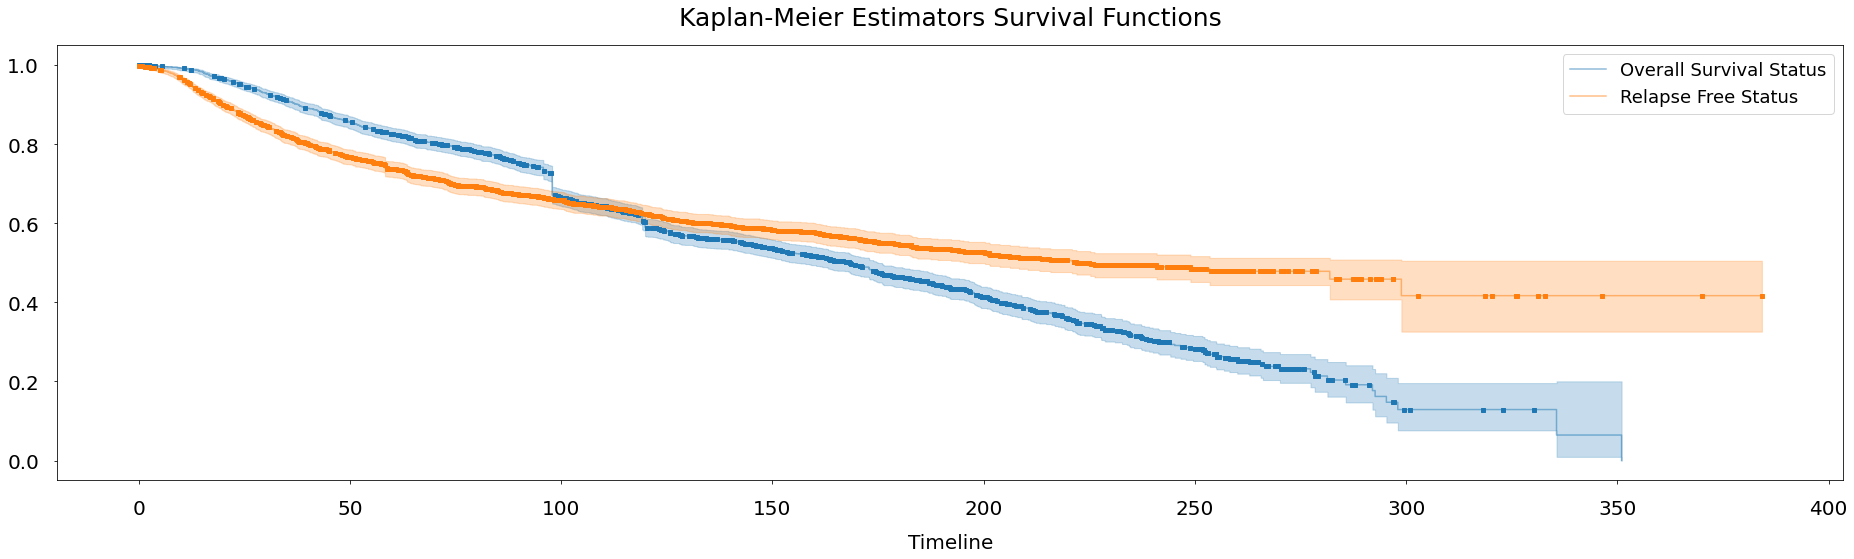

In [15]:
fig = plt.figure(figsize=(32, 8))

for time, event in zip(['Overall Survival (Months)', 'Relapse Free Status (Months)'], ['Overall Survival Status', 'Relapse Free Status']):
       
    T, E = train_df[time], train_df[event]
    kmf = KaplanMeierFitter()
    kmf.fit(T, E)
    kmf.plot(label=event, alpha=0.5, show_censors=True, censor_styles={'ms': 4, 'marker': 's'})
    
plt.xlabel('Timeline', size=20, labelpad=15)
plt.ylabel('')
plt.tick_params(axis='x', labelsize=20, pad=15)
plt.tick_params(axis='y', labelsize=20, pad=15)
plt.legend(prop={'size': 18})
plt.title('Kaplan-Meier Estimators Survival Functions', size=25, pad=20)

plt.show()

Kaplan-meier estimate can also be used for predicting survival probabilities of unseen data at given times. `lifelines.KaplanMeierFitter.predict` function takes `times` parameter which is a list of timesteps to predict probabilities at. For example, the model below tries to predict both events happening (separately) at 12, 24, and 36 months. Model is evaluated on 5 split cross-validation and unseen test set. 

0.5 Test ROC AUC scores suggest that Kaplan-Meier estimate fails to generalize on an unseen test set. That was expected because this model doesn't use patient covariates and it outputs same probabilities for every patient in the population. Besides low scores, Kaplan-Meier estimate doesn't output hazard rates, so it can't be evaluated with concordance index. That's why Kaplan-Meier estimate shouldn't be used for predictions, but it is very useful for exploratory data analysis.

In [ ]:
eval_horizons = [12, 24, 36]

for time, event in zip(['Overall Survival (Months)', 'Relapse Free Status (Months)'], ['Overall Survival Status', 'Relapse Free Status']):
    
    oof_survival_probs = pd.DataFrame(data=np.zeros((train_df.shape[0], len(eval_horizons))),
                                                index=train_df.index,
                                                columns=eval_horizons)
    test_survival_probs = pd.DataFrame(data=np.zeros((test_df.shape[0], len(eval_horizons))),
                                       index=test_df.index,
                                       columns=eval_horizons)
    
    for fold in sorted(train_df['fold'].unique()):
                    
        trn_idx, val_idx = train_df.loc[train_df['fold'] != fold].index, train_df.loc[train_df['fold'] == fold].index       
        T_trn, E_trn = train_df.loc[trn_idx, time], train_df.loc[trn_idx, event]
        T_val, E_val = train_df.loc[val_idx, time], train_df.loc[val_idx, event]
        kmf = KaplanMeierFitter()
        kmf.fit(T_trn, E_trn)
        
        survival_function = kmf.predict(times=eval_horizons)        
        val_survival_function = pd.DataFrame(data=np.transpose(np.tile(survival_function.values.reshape(-1, 1), T_val.shape[0])),
                                             index=val_idx,
                                             columns=eval_horizons)        
        oof_survival_probs.loc[val_idx, :] = val_survival_function.values        
        fold_test_survival = pd.DataFrame(data=np.transpose(np.tile(survival_function.values.reshape(-1, 1), test_df.shape[0])),
                                          index=test_df.index,
                                          columns=eval_horizons)
        test_survival_probs += (fold_test_survival.values / n_splits)

        val_auc = compute_time_dependent_auc(train_df.loc[val_idx, event], val_survival_function, train_df.loc[val_idx, time])
        print(f'Fold {fold} ({time}) - ROC AUC Scores {val_auc}')
        
    oof_auc = compute_time_dependent_auc(train_df[event], oof_survival_probs, train_df[time])
    test_auc = compute_time_dependent_auc(test_df[event], test_survival_probs, test_df[time])
    print(f'{"-" * 30}\nKaplan Meier Estimate {time} OOF AUC: {oof_auc}')
    print(f'Kaplan-Meier Estimate {time} Test AUC: {test_auc}\n{"-" * 30}\n')


Fold 1 (Overall Survival (Months)) - ROC AUC Scores {12: 0.5, 24: 0.5, 36: 0.5}
Fold 2 (Overall Survival (Months)) - ROC AUC Scores {12: 0.5, 24: 0.5, 36: 0.5}
Fold 3 (Overall Survival (Months)) - ROC AUC Scores {12: 0.5, 24: 0.5, 36: 0.5}
Fold 4 (Overall Survival (Months)) - ROC AUC Scores {12: 0.5, 24: 0.5, 36: 0.5}
Fold 5 (Overall Survival (Months)) - ROC AUC Scores {12: 0.5, 24: 0.5, 36: 0.5}
------------------------------
Kaplan Meier Estimate Overall Survival (Months) OOF AUC: {12: 0.649796, 24: 0.524038, 36: 0.518953}
Kaplan-Meier Estimate Overall Survival (Months) Test AUC: {12: 0.5, 24: 0.5, 36: 0.5}
------------------------------

Fold 1 (Relapse Free Status (Months)) - ROC AUC Scores {12: 0.5, 24: 0.5, 36: 0.5}
Fold 2 (Relapse Free Status (Months)) - ROC AUC Scores {12: 0.5, 24: 0.5, 36: 0.5}
Fold 3 (Relapse Free Status (Months)) - ROC AUC Scores {12: 0.5, 24: 0.5, 36: 0.5}
Fold 4 (Relapse Free Status (Months)) - ROC AUC Scores {12: 0.5, 24: 0.5, 36: 0.5}
Fold 5 (Relapse Fre

## 7. Cox Proportional Hazards Model (Semi-parametric Model)

Cox proportional hazards model is essentially a regression model commonly used in medical research for investigating the association between the survival time of patients and one or more covariates. The method mentioned above, Kaplan-Meier estimate is an example of univariate analysis. It describes the survival according to one factor under investigation, but ignore the impact of any others (patient covariates). Univariate analysis methods are only useful when the covariates are categorical (e.g.: males vs females). They don’t work easily for continuous covariates such as "age at diagnosis".

An alternative method to Kaplan-Meier estimate is the Cox proportional hazards model. It works for both continuous and categorical variables. Furthermore, the Cox proportional hazards model extends survival analysis methods to assess simultaneously the effect of several risk factors on survival time.

In [ ]:
eval_horizons = [12, 24, 36]

# Base covariates (original features)
base_covariates = ['Age at Diagnosis', 'Type of Breast Surgery', 'Cancer Type',
                   'Cancer Type Detailed', 'Cellularity', 'Chemotherapy',
                   'Pam50 + Claudin-low subtype', 'Cohort', 'ER status measured by IHC',
                   'ER Status', 'Neoplasm Histologic Grade', 'HER2 status measured by SNP6',
                   'HER2 Status', 'Tumor Other Histologic Subtype', 'Hormone Therapy',
                   'Inferred Menopausal State', 'Primary Tumor Laterality', 'Lymph nodes examined positive',
                   'Mutation Count', 'Nottingham prognostic index', 'Oncotree Code', 'PR Status',
                   '3-Gene classifier subtype', 'Tumor Size', 'Tumor Stage']

# Engineered features to add
engineered_features = ['Triple_Negative', 'Hormone_Receptor_Positive', 'ER_PR_Both_Positive',
                       'Treatment_Combination_Score', 'Tumor_Burden_Score', 'Age_Group',
                       'High_Lymph_Node_Involvement', 'High_Mutation_Burden']

# Filter to only include features that exist in the dataframe
os_covariates = [col for col in base_covariates + engineered_features if col in train_df.columns]
rfs_covariates = [col for col in base_covariates + engineered_features if col in train_df.columns]

print(f"Using {len(os_covariates)} covariates for Overall Survival model")
print(f"Using {len(rfs_covariates)} covariates for Relapse Free Status model")
print(f"\nEngineered features included: {[f for f in engineered_features if f in train_df.columns]}")

for time, event, covariates in zip(['Overall Survival (Months)', 'Relapse Free Status (Months)'],
                                   ['Overall Survival Status', 'Relapse Free Status'],
                                   [os_covariates, rfs_covariates]):
    
    oof_survival_probs = pd.DataFrame(data=np.zeros((train_df.shape[0], len(eval_horizons))), index=train_df.index, columns=eval_horizons)
    oof_partial_risk = pd.DataFrame(data=np.zeros(train_df.shape[0]), index=train_df.index, columns=['Partial Hazard Rates'])
    test_survival_probs = pd.DataFrame(data=np.zeros((test_df.shape[0], len(eval_horizons))), index=test_df.index, columns=eval_horizons)
    test_partial_risk = pd.DataFrame(data=np.zeros(test_df.shape[0]), index=test_df.index, columns=['Partial Hazard Rates'])
    
    for fold in sorted(train_df['fold'].unique()):
                    
        trn_idx, val_idx = train_df.loc[train_df['fold'] != fold].index, train_df.loc[train_df['fold'] == fold].index       
        trn = train_df.loc[trn_idx, covariates + [time, event]]
        val = train_df.loc[val_idx, covariates + [time, event]]
        
        cph = CoxPHFitter(baseline_estimation_method='breslow',
                          n_baseline_knots=4,
                          penalizer=1e-2)
        cph.fit(trn, duration_col=time, event_col=event)
        
        val_survival_function = cph.predict_survival_function(val, times=eval_horizons).T
        fold_test_survival = cph.predict_survival_function(test_df[covariates + [time, event]], times=eval_horizons).T
        oof_survival_probs.loc[val_idx, :] = val_survival_function.values
        test_survival_probs += (fold_test_survival.values / n_splits)
        
        oof_partial_risk.loc[val_idx, 'Partial Hazard Rates'] = -cph.predict_partial_hazard(val[covariates + [time, event]])
        test_partial_risk['Partial Hazard Rates'] += -cph.predict_partial_hazard(test_df[covariates + [time, event]])

        val_auc = compute_time_dependent_auc(train_df.loc[val_idx, event], val_survival_function, train_df.loc[val_idx, time])
        val_ci = concordance_index(train_df.loc[val_idx, time], oof_partial_risk.loc[val_idx, 'Partial Hazard Rates'], train_df.loc[val_idx, event])
        print(f'Fold {fold} ({time}) - ROC AUC Scores {val_auc} - Concordance Index: {val_ci:.6}')
        
    oof_auc = compute_time_dependent_auc(train_df[event], oof_survival_probs, train_df[time])
    oof_ci = concordance_index(train_df[time], oof_partial_risk['Partial Hazard Rates'], train_df[event])
    test_auc = compute_time_dependent_auc(test_df[event], test_survival_probs, test_df[time])
    test_ci = concordance_index(test_df[time], test_partial_risk['Partial Hazard Rates'], test_df[event])
    print(f'{"-" * 30}\nCox Proportional Hazards Model {time} - OOF ROC AUC Scores: {oof_auc} - Concordance Index: {oof_ci:.6}')
    print(f'Cox Proportional Hazards Model {time} - Test ROC AUC Scores: {test_auc} - Concordance Index: {test_ci:.6}\n{"-" * 30}\n')


Fold 1 (Overall Survival (Months)) - ROC AUC Scores {12: 0.405, 24: 0.215133, 36: 0.261681} - Concordance Index: 0.68849
Fold 2 (Overall Survival (Months)) - ROC AUC Scores {12: 0.302423, 24: 0.27154, 36: 0.271706} - Concordance Index: 0.668644
Fold 3 (Overall Survival (Months)) - ROC AUC Scores {12: 0.112228, 24: 0.318683, 36: 0.315144} - Concordance Index: 0.662762
Fold 4 (Overall Survival (Months)) - ROC AUC Scores {12: 0.144841, 24: 0.215091, 36: 0.23007} - Concordance Index: 0.668316
Fold 5 (Overall Survival (Months)) - ROC AUC Scores {12: 0.099578, 24: 0.246349, 36: 0.248634} - Concordance Index: 0.671966
------------------------------
Cox Proportional Hazards Model Overall Survival (Months) - OOF ROC AUC Scores: {12: 0.212921, 24: 0.254402, 36: 0.265274} - Concordance Index: 0.671959
Cox Proportional Hazards Model Overall Survival (Months) - Test ROC AUC Scores: {12: 0.29697, 24: 0.286557, 36: 0.236842} - Concordance Index: 0.65736
------------------------------

Fold 1 (Relapse

## References

* [[1] ("Survival Analysis", n.d.)](https://en.wikipedia.org/wiki/Survival_analysis)
* [[2] ("Introduction to survival analysis", n.d.)](https://lifelines.readthedocs.io/en/latest/Survival%20Analysis%20intro.html)
* [[3] ("Deep Learning for Survival Analysis", 2020)](https://humboldt-wi.github.io/blog/research/information_systems_1920/group2_survivalanalysis/#motivation)
* [[4] ("Kaplan meier survival curves and the log-rank test", 2013)](https://www.slideshare.net/zhe1/kaplan-meier-survival-curves-and-the-logrank-test)
* [[5] ("Applied Survival Analysis: Regression Modeling of Time-to-Event Data, 2nd Edition", 2011)](https://www.wiley.com/en-us/Applied+Survival+Analysis%3A+Regression+Modeling+of+Time+to+Event+Data%2C+2nd+Edition-p-9781118211588)
* [[6] ("The Basics of Survival Analysis", 2016)](https://tinyheero.github.io/2016/05/12/survival-analysis.html)
* [[7] ("On Ranking in Survival Analysis: Bounds on the Concordance Index", 2008)](https://www.slideshare.net/zhe1/kaplan-meier-survival-curves-and-the-logrank-test)
* [[8] ("When Should You Use Non-Parametric, Parametric, and Semi-Parametric Survival Analysis", 2018)](https://boostedml.com/2018/11/when-should-you-use-non-parametric-parametric-and-semi-parametric-survival-analysis.html#:~:text=The%20most%20common%20non%2Dparametric,in%20the%20presence%20of%20censoring.)